In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import MiniBatchKMeans
from MatrixFactorization import MatrixFactorization
from CollaborativeFiltering import CollaborativeFiltering as cb

In [3]:
movie_ratings = pd.read_csv('./dataset/ratings.csv')
movie_ratings_small = pd.read_csv('./dataset/ratings_small.csv')
movies_metadata = pd.read_csv('./dataset/movies_metadata.csv')

/var/folders/s7/_6xph2kx7zj1t3c3tmb0gk5c0000gn/T/ipykernel_3781/2452708455.py:3: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  movies_metadata = pd.read_csv('./dataset/movies_metadata.csv')


In [4]:
movie_ratings_small.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [5]:
movie_ratings.shape, movie_ratings_small.shape

((26024289, 4), (100004, 4))

In [6]:
movies_metadata = movies_metadata.drop_duplicates(subset='id', keep='first')

In [7]:
movies_metadata = movies_metadata[movies_metadata['id'].str.isdigit()]
movies_metadata['id'] = movies_metadata['id'].astype('int64')

In [47]:
# 두 데이터프레임 병합 (movieId 기준)
movies_total= movies_metadata.merge(movie_ratings,
                                        left_on='id',
                                        right_on='movieId',
                                        how='left')

# 필요 없어진 movieId 열 제거
movies_total = movies_total.drop(columns=['movieId'])


In [48]:
movies_total.shape

(11474436, 27)

In [49]:
movies_total.dropna(subset='userId', inplace=True)

In [50]:
movies_total['userId'] = movies_total['userId'].astype('int64')

In [51]:
a =movies_total[['id','original_title','userId', 'rating']]
a.head()

,id,original_title,userId,rating
0,862,Toy Story,1923,3.0
1,862,Toy Story,2103,5.0
2,862,Toy Story,5380,1.0
3,862,Toy Story,6177,4.0
4,862,Toy Story,6525,4.0


In [52]:
user_matrix = pd.pivot_table(a, index="userId", columns='original_title',values='rating',aggfunc="mean", fill_value=0)
user_matrix

original_title,!Women Art Revolution,$5 a Day,'Gator Bait,'R Xmas,'Twas the Night Before Christmas,(A)Sexual,...And the Pursuit of Happiness,...Più forte ragazzi!,...altrimenti ci arrabbiamo!,00 Schneider - Jagd auf Nihil Baxter,...,친절한 금자씨,태풍,파란대문,하울링,해안선,헬로우 고스트,형사 Duelist,활,회사원,２０世紀少年< 第1章> 終わりの始まり
userId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
270892,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.5,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
270893,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
270894,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [53]:
import numpy as np
from sklearn.decomposition import TruncatedSVD
from scipy.sparse import csr_matrix

# 추천 결과 평가 함수
def precision_recall_at_k(usermatrix, k, top_n=10):
    usermatrix_sparse = csr_matrix(usermatrix)  # 희소 행렬 변환
    svd = TruncatedSVD(n_components=k)  # k 차원으로 축소
    user_factors = svd.fit_transform(usermatrix_sparse)
    item_factors = svd.components_  # 아이템 특성 벡터
    
    # # 예측된 평점 행렬 (유저 x 아이템)
    predictions = np.dot(user_factors, item_factors)
    
    # Precision@K 및 Recall@K 계산
    precision_scores, recall_scores = [], []
    
    for user_idx in range(usermatrix.shape[0]):  
        #true_items = set(np.where(usermatrix[user_idx] > 0)[0])  
        true_items = set(np.where(user_matrix.iloc[user_idx] > 0)[0]) # 실제 선호한 아이템
        if len(true_items) == 0: continue  # 실제 데이터가 없는 경우 제외
        
        pred_items = np.argsort(-predictions[user_idx])[:top_n]  # 예측된 상위 N개 아이템
        hit_items = true_items.intersection(set(pred_items))
        
        precision = len(hit_items) / top_n
        recall = len(hit_items) / len(true_items)
        
        precision_scores.append(precision)
        recall_scores.append(recall)

    return np.mean(precision_scores), np.mean(recall_scores)

# k 값 조절하면서 Precision@K & Recall@K 계산
k_values = [10, 20]
precision_results, recall_results = [], []

for k in k_values:
    precision, recall = precision_recall_at_k(user_matrix, k)
    precision_results.append(precision)
    recall_results.append(recall)
    print(f"k={k} → Precision@10: {precision:.4f}, Recall@10: {recall:.4f}")

k=10 → Precision@10: 0.4556, Recall@10: 0.2222
k=20 → Precision@10: 0.5228, Recall@10: 0.2713


In [43]:
user_idx = 0
user = set(np.where(user_matrix.iloc[user_idx] > 0)[0])
user

{144, 885, 1065, 1508, 1759, 2564}

/Users/chahyeon-yeong/miniconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 53364 (\N{HANGUL SYLLABLE KEUL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/chahyeon-yeong/miniconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 47084 (\N{HANGUL SYLLABLE REO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/chahyeon-yeong/miniconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 49828 (\N{HANGUL SYLLABLE SEU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/chahyeon-yeong/miniconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 53552 (\N{HANGUL SYLLABLE TEO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/chahyeon-yeong/miniconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 44

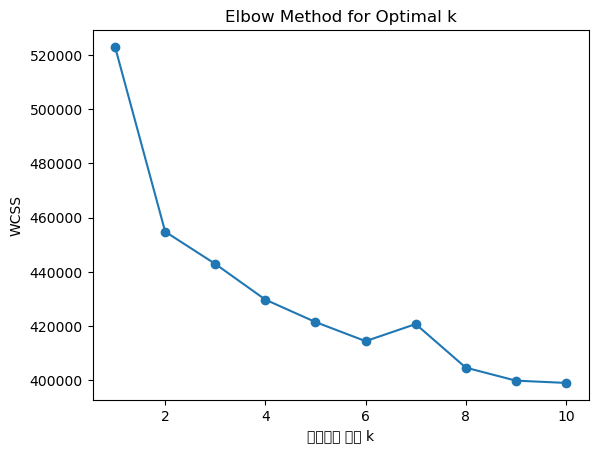

In [42]:
#kmeans를 사용하여 사용자-아이템 메트릭스를 클러스터링을 먼저 시행한다.
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans

# 예제 데이터 (사용자-아이템 행렬)
pca = PCA(n_components=235)
X_reduced = pca.fit_transform(user_matrix.T)

wcss = []
for k in range(1, 11):  # k를 1부터 10까지 테스트
    kmeans = MiniBatchKMeans(n_clusters=k, random_state=42, batch_size=500)
    kmeans.fit(X_reduced)
    wcss.append(kmeans.inertia_)  # inertia_ = WCSS 값

# 그래프 그리기
plt.plot(range(1, 11), wcss, marker='o')
plt.xlabel('클러스터 개수 k')
plt.ylabel('WCSS')
plt.title('Elbow Method for Optimal k')
plt.show()

Text(0, 0.5, 'Silhouette Score')

/Users/chahyeon-yeong/miniconda3/lib/python3.12/site-packages/IPython/core/events.py:82: UserWarning: Glyph 53364 (\N{HANGUL SYLLABLE KEUL}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/Users/chahyeon-yeong/miniconda3/lib/python3.12/site-packages/IPython/core/events.py:82: UserWarning: Glyph 47084 (\N{HANGUL SYLLABLE REO}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/Users/chahyeon-yeong/miniconda3/lib/python3.12/site-packages/IPython/core/events.py:82: UserWarning: Glyph 49828 (\N{HANGUL SYLLABLE SEU}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/Users/chahyeon-yeong/miniconda3/lib/python3.12/site-packages/IPython/core/events.py:82: UserWarning: Glyph 53552 (\N{HANGUL SYLLABLE TEO}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/Users/chahyeon-yeong/miniconda3/lib/python3.12/site-packages/IPython/core/events.py:82: UserWarning: Glyph 44060 (\N{HANGUL SYLLABLE GAE}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/Users/ch

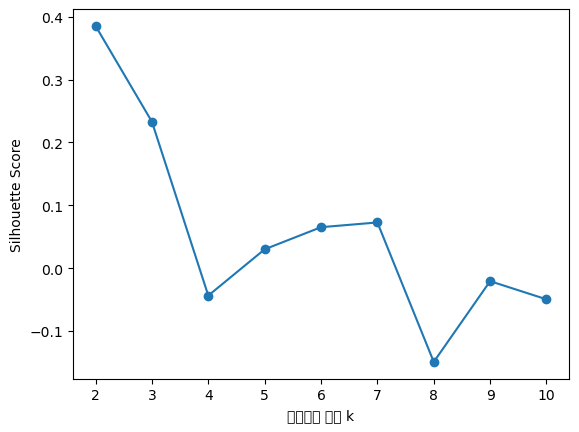

In [43]:
from sklearn.metrics import silhouette_score

silhouette_scores = []
pca = PCA(n_components=235)
X_reduced = pca.fit_transform(user_matrix)
silhouette_scores = []
# Silhouette Score 계산을 위한 샘플링 비율 설정 (예: 10% 샘플링)
sample_ratio =1
X_sampled = X_reduced[np.random.choice(X_reduced.shape[0], int(X_reduced.shape[0] * sample_ratio), replace=False)]
for k in range(2, 11):  # k=1은 의미 없으므로 2부터 시작
    kmeans = MiniBatchKMeans(n_clusters=k, random_state=42, batch_size=200, n_init=1)
    cluster_labels = kmeans.fit_predict(X_sampled)
    score = silhouette_score(X_sampled, cluster_labels)
    silhouette_scores.append(score)

# 그래프 그리기
plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.xlabel('클러스터 개수 k')
plt.ylabel('Silhouette Score')

In [44]:
silhouette_scores

[0.38540981687572573,
 0.23295668744956935,
 -0.04355261140441286,
 0.030104038053841306,
 0.06525846876453166,
 0.07279595616325381,
 -0.1490513431001018,
 -0.020599095898045074,
 -0.04948533382863566]

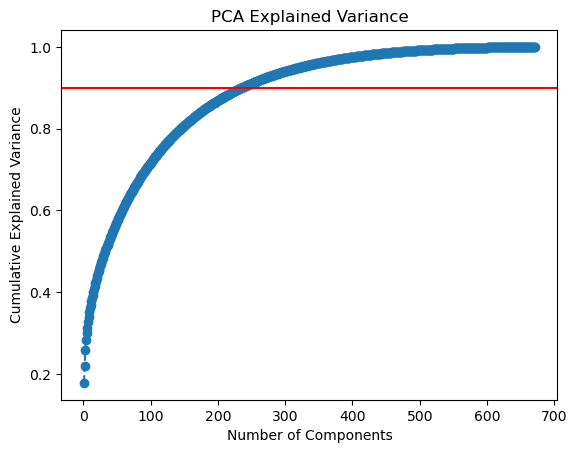

90% 이상 설명하는 최소 차원 개수: 235


In [15]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# PCA 적용
pca = PCA()
X_reduced = pca.fit_transform(user_matrix.T)

# 누적 설명 분산 비율 계산
explained_variance = np.cumsum(pca.explained_variance_ratio_)

# 그래프 그리기
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', linestyle='--')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Explained Variance')
plt.axhline(y=0.9, color='r', linestyle='-')  # 90% 선
plt.show()

# 90% 이상의 분산을 설명하는 최소 차원 개수 찾기
optimal_components = np.argmax(explained_variance >= 0.9) + 1
print(f"90% 이상 설명하는 최소 차원 개수: {optimal_components}")


In [13]:
k = 2
kmeans = MiniBatchKMeans(n_clusters=k, random_state=42, batch_size=500)
item_clusters = kmeans.fit_predict(user_matrix.T)
unique_clusters = np.unique(item_clusters)
item_id = '장화, 홍련'
item_cluster_map = pd.Series(item_clusters, index=user_matrix.T.index)

# 특정 item_id의 군집 찾기
cluster_id = item_cluster_map.loc[item_id]
print(f"'{item_id}'은(는) {cluster_id}번 군집에 속합니다.")

# top_k = 10

cluster_indices = np.where(item_clusters == cluster_id)[0]  # 해당 클러스터 사용자 인덱스
cluster_matrix = user_matrix.T.iloc[cluster_indices]


'장화, 홍련'은(는) 1번 군집에 속합니다.


In [14]:
cluster_matrix.shape

(2616, 671)

In [21]:
mf = MatrixFactorization(cluster_matrix)
k_values = [50, 100,150,200]  # 실험할 k 값 리스트
for k in k_values:
    actual_items, predicted_items = mf.predict(k, 10, False)
    precision = mf.precision_at_k(actual_items, predicted_items)
    print(f"k={k}, Precision: {precision:.4f}")

k=50, Precision: 0.4425
k=100, Precision: 0.4887
k=150, Precision: 0.5043
k=200, Precision: 0.5127


In [22]:
mf = MatrixFactorization(cluster_matrix)
k_values = [300, 400, 500]  # 실험할 k 값 리스트
for k in k_values:
    actual_items, predicted_items = mf.predict(k, 10, False)
    precision = mf.precision_at_k(actual_items, predicted_items)
    print(f"k={k}, Precision: {precision:.4f}")

k=300, Precision: 0.5177
k=400, Precision: 0.5188
k=500, Precision: 0.5189


In [ ]:
k_values = [100, 200, 300, 400,500]  # 실험할 k 값 리스트
for k in k_values:
    actual_items, predicted_items = mf.predict(k, 10, False)
    recall = mf.recall_at_k(actual_items, predicted_items)
    print(f"k={k}, Recall: {recall:.4f}")

k=100, Recall: 0.8054
k=200, Recall: 0.8491
k=300, Recall: 0.8579
k=400, Recall: 0.8599
k=500, Recall: 0.8605


In [15]:
optimal_k = 100
cb_2 = cb(cluster_matrix, optimal_k)
item_title = "장화, 홍련"
idx = cluster_matrix.index.get_loc(item_title)
similarities = cb_2.adjusted_cosine_similarity()

In [16]:
similarities

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 6843456 stored elements and shape (2616, 2616)>

In [17]:
user_id = 1
ratings = cb_2.item_based_predict(idx, user_id)
print(f"사용자 {user_id}가 '{item_id}'에 부여할 예측 평점: {ratings}")

사용자 1가 '장화, 홍련'에 부여할 예측 평점: 2.1729519409140856


In [23]:
k = 2 # 위의결과로 설정됨
kmeans = MiniBatchKMeans(n_clusters=k, random_state=42, batch_size=500)
user_clusters = kmeans.fit_predict(user_matrix)
unique_clusters = np.unique(user_clusters)

user_id = 0  # 예: 첫 번째 사용자
cluster= user_clusters[0]

top_k = 10

cluster_indices = np.where(user_clusters == cluster)[0]  # 해당 클러스터 사용자 인덱스
cluster_matrix = user_matrix.iloc[cluster_indices]
optimal_k = 100
cb_= cb(cluster_matrix, optimal_k)
similarities = cb_.calculate_pearson_similarity(user_id)

In [24]:
item_id = "장화, 홍련"
user_id = 1
predicted_rating = cb_.user_based_predict(user_id, item_id, similarities)
print(f"사용자 {user_id}가 '{item_id}'에 부여할 예측 평점: {predicted_rating}")

사용자 1가 '장화, 홍련'에 부여할 예측 평점: 2.3333333333333335
